In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


def model_evaluation(history, model, x_test,y_test, field_name):
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(history.history['loss'], label="Loss")
    ax[0].plot(history.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(history.history['acc'], label="Accuracy")
    ax[1].plot(history.history['val_acc'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    test_pred = model.predict(x_test)
    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), y_test).sum()/y_test.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    plt.ylabel('Accuracy')
    plt.show()

    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=y_test.columns))

    test_result = model.evaluate(x_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_result[0], test_result[1])

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
def visualize_layer_kernels(img, conv_layer, title):
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]
    f, ax = plt.subplots(kernels_num, 3, figsize=(7, kernels_num*2))

    for i in range(0, kernels_num):
        kernel=kernels[:,:,:3,i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize = 9)
        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)
        img_filt = scipy.ndimage.filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()   

In [4]:
train_dir = '../input/lego brick images/LEGO brick images/train'
val_dir ='../input/lego brick images/LEGO brick images/valid'


augs_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,validation_split=0.2)  

train_gen = augs_gen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=16,
    class_mode = 'categorical',
    shuffle=True
)

test_gen = augs_gen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 6379 images belonging to 16 classes.
Found 6379 images belonging to 16 classes.


In [5]:
def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(Conv2D(filters,(3,3),activation='selu'))
        model.add(SeparableConv2D(filters, (3, 3), activation='selu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(150, 150, 3)))
    ConvBlock(model, 1, 32)
    ConvBlock(model, 1, 64)
    ConvBlock(model, 1, 128)
    ConvBlock(model, 1, 256)
    model.add(Flatten())
    model.add(Dense(1024,activation='selu'))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='softmax'))
    return model

model = FCN()
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 146, 146, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 69, 69, 64)        4736      
__________

In [6]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [7]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 100, 
    validation_data  = test_gen,
    validation_steps = 100,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
100/100 [==============================] - 32s 324ms/step - loss: 0.3055 - acc: 0.9187 - val_loss: 0.1582 - val_acc: 0.9391

Epoch 00001: val_loss improved from inf to 0.15820, saving model to ./base.model
Epoch 2/20
100/100 [==============================] - 29s 291ms/step - loss: 0.2333 - acc: 0.9249 - val_loss: 0.1795 - val_acc: 0.9416

Epoch 00002: val_loss did not improve from 0.15820
Epoch 3/20
100/100 [==============================] - 29s 294ms/step - loss: 0.2053 - acc: 0.9326 - val_loss: 0.1326 - val_acc: 0.9460

Epoch 00003: val_loss improved from 0.15820 to 0.13263, saving model to ./base.model
Epoch 4/20
100/100 [==============================] - 29s 290ms/step - loss: 0.1812 - acc: 0.9366 - val_loss: 0.1251 - val_acc: 0.9525

Epoch 00004: val_loss improved from 0.13263 to 0.12509, saving model to ./base.model
Epoch 5/20
100/100 [==============================] - 26s 264ms/step - loss: 0.1697 - acc: 0.9393 - val_loss: 0.0982 - val_acc: 0.9604

Epoch 00005: val_l

Model Test Loss: 0.09962183180034034
Model Test Accuracy: 0.9622589747609344
Weights Saved


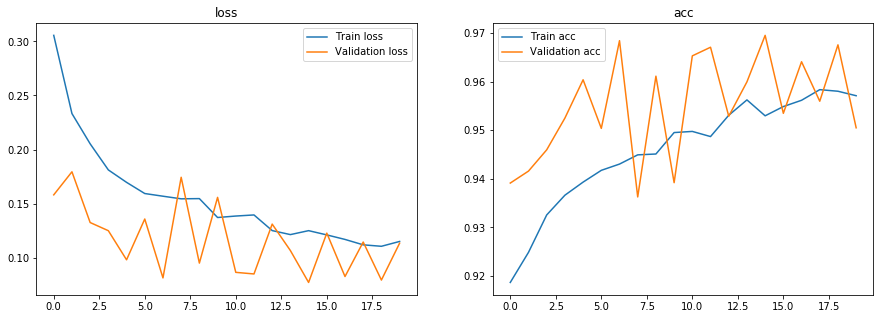

In [8]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(test_gen)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

In [9]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


--2019-02-19 17:07:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.9.93, 52.4.75.11, 52.73.94.166, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.9.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.55MB/s    in 0.5s    

2019-02-19 17:07:39 (9.55 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://502c97ed.ngrok.io
